# **AEC-CapsNet Brain Jun Cheng**

# Importing libraries

In [ ]:
 !pip install tensorflow==2.15.0

In [ ]:
#!pip install tensorflow==2.14.0

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import keras.layers as L
import keras.models as M
import keras.initializers as I
import keras.backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2,os
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow
import csv
import math
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix , classification_report,accuracy_score, ConfusionMatrixDisplay, recall_score
from keras.layers import BatchNormalization


In [ ]:
data_path='/content/drive/MyDrive/Dataset/Jun Cheng Brain MRI dataset/'
categories=os.listdir(data_path)

print(categories)
labels = ['1', '2', '3']
label_dict = {label: i for i, label in enumerate(labels)}

['1', '3', '2']


In [ ]:
img_size=65

In [ ]:
folder='/content/drive/MyDrive/Dataset/Jun Cheng Brain MRI dataset/'
images = []
img_labels = []
for label in labels:
    path = f"{folder}/{label}"
    for filename in os.listdir(path):
        # img = Image.open(os.path.join(path, filename)).convert('L')  # grayscale
        img = Image.open(os.path.join(path, filename)).convert('RGB')
        img = img.resize((img_size, img_size))
        img = np.array(img)
        if img is not None:
            images.append(img)
            img_labels.append(label_dict[label])
data=np.array(images)
label=np.array(img_labels)
print('data', data.shape)
print('label', label.shape)


data (3040, 65, 65, 3)
label (3040,)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Original dataset shape Counter({1: 1432, 2: 937, 0: 671})
Resampled dataset shape Counter({0: 1432, 1: 1432, 2: 1432})


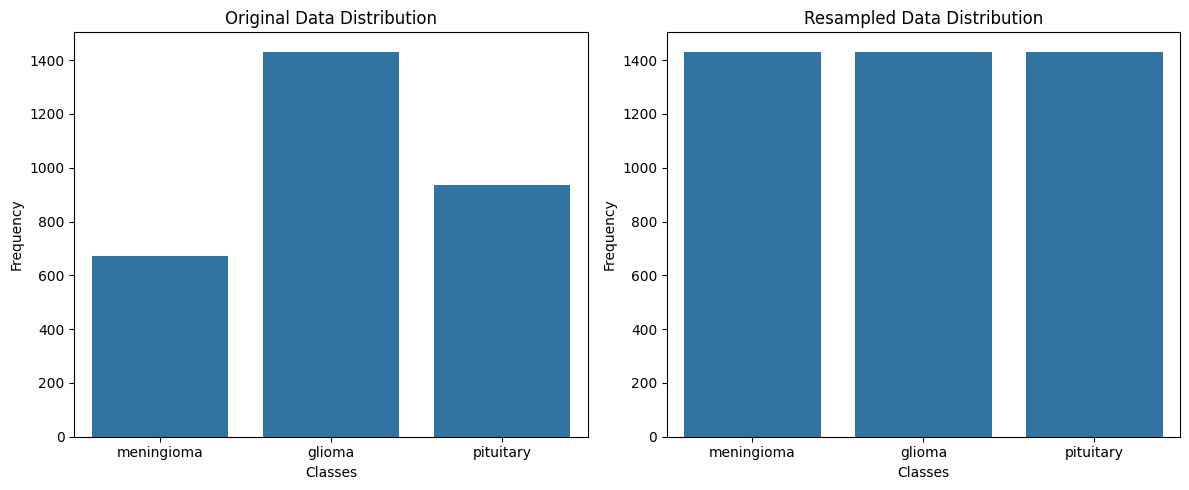

In [ ]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Convert your data and label lists to numpy arrays
data_np = np.array(data)
label_np = np.array(label)

# Reshape the data for oversampling
data_reshaped = data_np.reshape(data_np.shape[0], -1)

# Use RandomOverSampler for oversampling
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(data_reshaped, label_np)

# Reshape the data to its original shape
x_resampled = x_resampled.reshape(-1, img_size, img_size, 3)

print(f"Original dataset shape {Counter(label_np)}")
print(f"Resampled dataset shape {Counter(y_resampled)}")

# Define the ordering for the x-axis labels
order_labels = [0, 1, 2]
class_names = ['meningioma', 'glioma', 'pituitary']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=label_np, order=order_labels)
plt.title("Original Data Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(ticks=order_labels, labels=class_names)  # Setting the x-axis tick labels


# Plot the resampled data distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, order=order_labels)
plt.title("Resampled Data Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(ticks=order_labels, labels=class_names)  # Setting the x-axis tick labels

plt.tight_layout()
plt.show()


In [ ]:
# data =np.array(data)
# label=np.array(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
x_train = X_train.astype('float32') / 255.
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(to_categorical(y_train.astype('float32')))

x_test = X_test.astype('float32') / 255.
x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(to_categorical(y_test.astype('float32')))
print(x_train.shape)


(3436, 65, 65, 3)


In [ ]:
#Define the range of batch size for network
def find_factors(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors


print(find_factors(x_train.shape[0]))

[1, 2, 4, 859, 1718, 3436]


In [ ]:
# Makign the squash function
def squash(vectors, axis=-1):
    squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = squared_norm / (1 + squared_norm) / (K.sqrt(squared_norm) + K.epsilon())
    return scale * vectors

In [ ]:
# Making capsule layer from scratch
class CapsuleLayer(L.Layer):
    def __init__(self, num_capsule, dim_capsule, routing=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routing = routing
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        assert len(input_shape) >= 3
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # transforming the matrix
        self.W = self.add_weight(
            shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=self.kernel_initializer, name='w')
        self.built = True

    def call(self, inputs, training=None):
        input_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)
        inputs_tiled = K.tile(input_expand, [1, self.num_capsule, 1, 1, 1])
        input_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        # b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routing > 0
        for i in range(self.routing):
            c = tf.nn.softmax(b, axis=1)
            output = squash(tf.matmul(c, input_hat))
            if i < self.routing - 1:
                b += tf.matmul(output, input_hat, transpose_b=True)
        return tf.squeeze(output)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:

from keras.src.layers import MaxPooling2D
from keras.src.layers.regularization.dropout import Dropout
batch_size = 2

img_shape = (img_size, img_size, 3)

# # Define a custom input layer with a hardcoded batch size
input_layer = L.Input(batch_shape=(batch_size,) + img_shape)


from keras.layers import DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Multiply

def powerfeature(input_layer, num_layers, expansion_factor, reduction_factor=0.9):

    x = L.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_layer)
    x = L.Dropout(0.2)(x)
    x = L.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)

    x = L.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.Dropout(0.3)(x)
    x = L.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)


    for _ in range(num_layers):
        x1 = L.Conv2D(2 * expansion_factor, (3, 3), kernel_initializer='he_normal', padding='same')(x)
        x1 = L.Dropout(0.2)(x1)
        x1 = L.Conv2D(expansion_factor, (3, 3), kernel_initializer='he_normal', padding='same')(x1)
        x = L.Concatenate()([x, x1])


    # Attention Mechanism
    attention = GlobalAveragePooling2D()(x)
    attention = Reshape((1, 1, K.int_shape(x)[-1]))(attention)
    attention = L.Conv2D(K.int_shape(x)[-1] // 16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(attention)
    attention = L.Conv2D(K.int_shape(x)[-1], (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(attention)
    x = Multiply()([x, attention])


 # Transition Mechanism
    contracted_filters = int(K.int_shape(x)[-1] * reduction_factor)

    x = L.Conv2D(contracted_filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = L.Dropout(0.5)(x)
    x = L.Conv2D(contracted_filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = L.MaxPooling2D((2, 2))(x)

    return x


x = powerfeature(input_layer,num_layers=2, expansion_factor=4)



#Primary Capsule Layer
conv2 = L.Conv2D(filters=8 * 16, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
reshape2 = L.Reshape([-1, 8])(conv2)  # Reduce dimensions here
squashed_output = L.Lambda(squash)(reshape2)


In [ ]:
braincaps = CapsuleLayer(num_capsule=3, dim_capsule=8, routing=3, name='braincaps')(squashed_output)

In [ ]:
# Making length layer which will calculate the length of the vectors
class Length(L.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


In [ ]:
# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(braincaps)

In [ ]:
# Making the masking layer
class Mask(L.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config

In [ ]:
y = L.Input(shape=(3,))
print(y.shape)
print(braincaps.shape)
masked_by_y = Mask()([braincaps, y])  # The true label is used to mask the output of capsule layer. For training
print(masked_by_y.shape)
masked = Mask()(braincaps)
print(masked.shape)

(None, 3)
(2, 3, 8)
(2, 24)
(2, 24)


In [ ]:
input_shape = x_train.shape[1:]
decoder = M.Sequential(name='decoder')
decoder.add(L.Dense(512, activation='relu', input_dim=8 * 3))
decoder.add(L.Dense(1024, activation='relu'))
decoder.add(L.Dense(img_size * img_size * 3, activation='softmax'))
decoder.add(L.Reshape(target_shape=input_shape, name='out_recon'))


In [ ]:
# Making models
train_model = M.Model([input_layer, y], [out_caps, decoder(masked_by_y)])
eval_model = M.Model(input_layer, [out_caps, decoder(masked)])

In [ ]:
# Making the loss function
def margin_loss(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [ ]:
train_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(2, 65, 65, 3)]             0         []                            
                                                                                                  
 conv2d (Conv2D)             (2, 65, 65, 64)              1792      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (2, 65, 65, 64)              0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (2, 65, 65, 64)              36928     ['dropout[0][0]']             
                                                                                              

In [ ]:
train_model.save_weights('/content/drive/MyDrive/models/NewBrain2_ACTCAPSNET_model.weights.h5')
train_model.load_weights('/content/drive/MyDrive/models/NewBrain2_ACTCAPSNET_model.weights.h5')


In [ ]:
n_samples = 5

In [ ]:
# plt.figure(figsize=(n_samples * 2, 3))
# for index in range(n_samples):
#     plt.subplot(1, n_samples, index + 1)
#     sample_image = x_test[index]
#     plt.imshow(sample_image, cmap="binary")
#     plt.title("Label:" + str(y_test[index]))
#     plt.axis("off")

# plt.show()

In [ ]:
m = batch_size
epochs = 60
# Using EarlyStopping, end training when val_accuracy is not improved for 10 consecutive times
early_stopping = keras.callbacks.EarlyStopping(monitor='val_capsnet_accuracy', mode='max',
                                               patience=2, restore_best_weights=True)


In [ ]:
print(x_train.shape)  # should be (num_samples, 28, 28, 1) or something similar
print(y_train.shape)  # should be (num_samples, 3) given your model summary
print(x_test.shape)   # should be (num_test_samples, 28, 28, 1) or similar
print(y_test.shape)   # should be (num_test_samples, 3)


(3436, 65, 65, 3)
(3436, 3)
(860, 65, 65, 3)
(860, 3)


In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_capsnet_accuracy', mode='max', factor=0.5, patience=4)
train_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss=[margin_loss, 'mse'], loss_weights=[1., 0.0005],
                    metrics=['accuracy'])

history= train_model.fit([x_train, y_train], [y_train, x_train], batch_size=m, epochs=epochs,
                validation_data=([x_test, y_test], [y_test, x_test])
                # , callbacks=[tensorboard_callback]
                )


Epoch 1/60
1718/1718 [==============================] - 45s 18ms/step - loss: 0.2335 - capsnet_loss: 0.2334 - decoder_loss: 0.1131 - capsnet_accuracy: 0.6234 - decoder_accuracy: 0.3318 - val_loss: 0.1614 - val_capsnet_loss: 0.1614 - val_decoder_loss: 0.1129 - val_capsnet_accuracy: 0.7651 - val_decoder_accuracy: 0.3324
Epoch 2/60
1718/1718 [==============================] - 29s 17ms/step - loss: 0.1476 - capsnet_loss: 0.1476 - decoder_loss: 0.1131 - capsnet_accuracy: 0.8024 - decoder_accuracy: 0.3323 - val_loss: 0.1180 - val_capsnet_loss: 0.1179 - val_decoder_loss: 0.1129 - val_capsnet_accuracy: 0.8314 - val_decoder_accuracy: 0.3311
Epoch 3/60
1718/1718 [==============================] - 29s 17ms/step - loss: 0.1144 - capsnet_loss: 0.1143 - decoder_loss: 0.1131 - capsnet_accuracy: 0.8559 - decoder_accuracy: 0.3324 - val_loss: 0.0945 - val_capsnet_loss: 0.0945 - val_decoder_loss: 0.1129 - val_capsnet_accuracy: 0.8860 - val_decoder_accuracy: 0.3340
Epoch 4/60
1718/1718 [==================

In [ ]:
evaluation_results = train_model.evaluate([x_test, y_test], [y_test, x_test], batch_size=m, verbose=0)
# print("Test Loss:", evaluation_results[0])
# print("Test Accuracy:", evaluation_results[3])

test_loss = evaluation_results[1]
test_accuracy = evaluation_results[3]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.0225
Test Accuracy: 97.67%


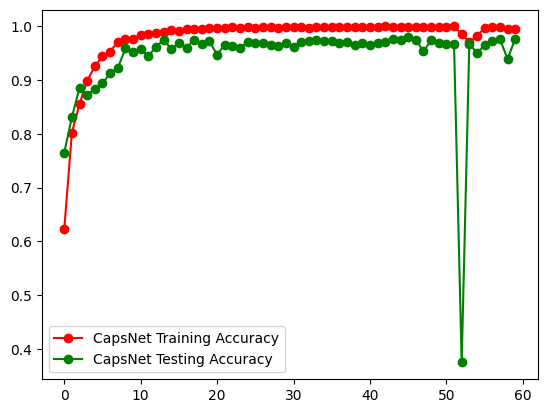

In [ ]:
plt.plot(history.history["capsnet_accuracy"] , 'ro-' , label = "CapsNet Training Accuracy")
plt.plot(history.history["val_capsnet_accuracy"] , 'go-' , label = "CapsNet Testing Accuracy")
plt.legend()
plt.show()

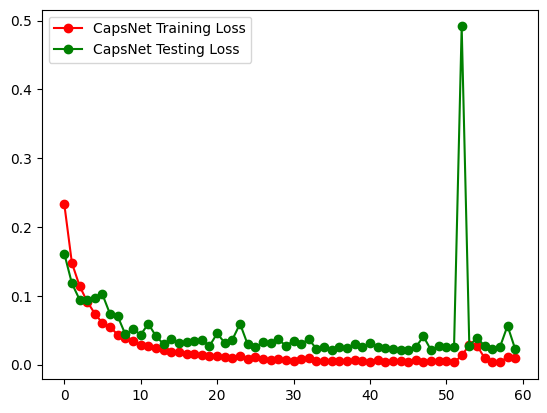

In [ ]:
plt.plot(history.history["capsnet_loss"] , 'ro-' , label = "CapsNet Training Loss")
plt.plot(history.history["val_capsnet_loss"] , 'go-' , label = "CapsNet Testing Loss")
plt.legend()
plt.show()

In [ ]:
classes = {0: ('1','meningioma'),
           1: ('2','glioma'),
           2: ('3','pituitary')
           }

In [ ]:
y_pred_list = train_model.predict([x_test, y_test], batch_size=m, verbose=0)  # Providing both image and label data
y_pred_capsnet = y_pred_list[0]   # Getting the output from the capsnet layer
y_pred_labels = np.argmax(y_pred_capsnet, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(y_pred_labels.shape)


(860,)


In [ ]:
target_names = [f"{classes[i]}" for i in range(3)]
print(classification_report(y_test_labels, y_pred_labels, target_names=target_names))

                     precision    recall  f1-score   support

('1', 'meningioma')       0.96      0.97      0.97       277
    ('2', 'glioma')       0.97      0.96      0.97       297
 ('3', 'pituitary')       1.00      1.00      1.00       286

           accuracy                           0.98       860
          macro avg       0.98      0.98      0.98       860
       weighted avg       0.98      0.98      0.98       860



430/430 [==============================] - 2s 4ms/step
A.I predicts: 1


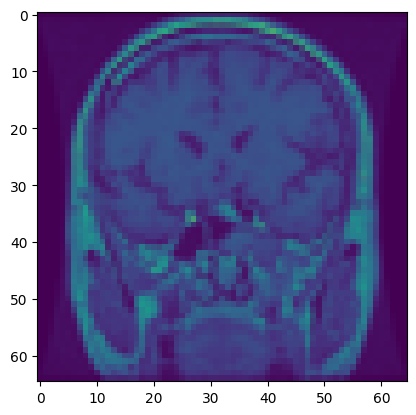

In [ ]:
from keras.models import Model
simplified_model = Model(inputs=train_model.input, outputs=train_model.get_layer('capsnet').output)
y_pred_capsnet = simplified_model.predict([x_test, y_test], batch_size=m)
y_pred_labels = np.argmax(y_pred_capsnet, axis=1)

X = 130

# Preprocessing the image
img_single = x_test[X]
img_single_exp = np.expand_dims(img_single, 0)
img_single_exp = img_single_exp.reshape(img_single_exp.shape[0], img_size, img_size, 3)

# Ensure y_test is 2D (like one-hot encoded labels)
if len(y_test.shape) != 2:
    print("y_test doesn't have two dimensions. Please check its shape!")
else:
    # Creating a dummy label to make a prediction since our model expects 2 inputs
    dummy_label = np.zeros((1, y_test.shape[1]))

    # Making the prediction for the single image
    # predictions_list = train_model.predict([img_single_exp, dummy_label])


    predictions_single = y_pred_labels[0]  # Extracting capsnet predictions

        # Ensure the predicted category index doesn't exceed the categories list length
    predicted_index = np.argmax(predictions_single)
    if predicted_index >= len(categories):
        print("Predicted index out of range for categories list!")
    else:
        print('A.I predicts:', categories[predicted_index])

# Visualizing the preprocessed image
plt.imshow(np.squeeze(img_single_exp), cmap='gray')
plt.grid(False)
plt.show()


In [ ]:
from keras.models import Model
simplified_model = Model(inputs=train_model.input, outputs=train_model.get_layer('capsnet').output)
y_pred_capsnet = simplified_model.predict([x_test, y_test], batch_size=m)
y_pred_labels = np.argmax(y_pred_capsnet, axis=1)



430/430 [==============================] - 2s 3ms/step


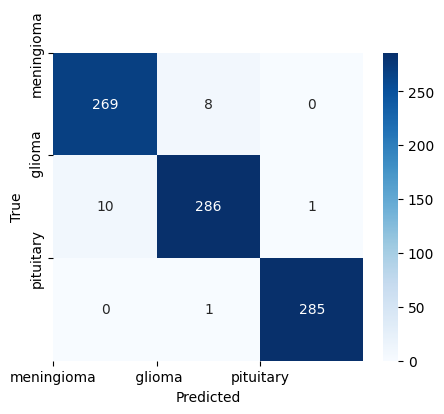

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

if y_test.shape[1] > 1:  # This checks if y_test is one-hot encoded
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(3), ['meningioma', ' glioma', 'pituitary'], fontsize=10)
plt.yticks(range(3), ['meningioma', ' glioma', 'pituitary'], fontsize=10)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model
fpr = dict()
tpr = dict()
roc_auc = dict()

simplified_model = Model(inputs=train_model.input, outputs=train_model.get_layer('capsnet').output)
y_pred_capsnet = simplified_model.predict([x_test, y_test], batch_size=m).round()
y_pred_labels = np.argmax(y_pred_capsnet, axis=1)

Y_test_1hot = to_categorical(y_test).round()
Y_train_1hot = to_categorical(y_train).round()

fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure y_test is one-hot encoded, if not, convert it
if y_test.shape[1] <= 1:
    print("y_test doesn't appear to be one-hot encoded. Please check its shape!")
else:
    Y_test_1hot = y_test
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(Y_test_1hot[:, i], y_pred_capsnet[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_1hot.ravel(), y_pred_capsnet.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

430/430 [==============================] - 2s 4ms/step


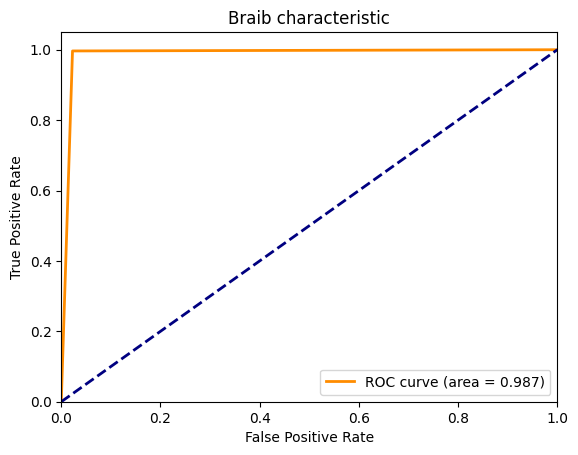

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Braib characteristic')
plt.legend(loc="lower right")
plt.show()